In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

print("Tensorflow version: {}".format(tf.__version__))

Tensorflow version: 1.12.0


# Data Preparation

Download the flower dataset.
```sh
curl -LO http://download.tensorflow.org/example_images/flower_photos.tgz
tar xzf flower_photos.tgz
```

Download the pretrained model from tf.hub. Here we use nasnet version 1 as the example.
```sh
mkdir /notebooks/nasnet
curl -L "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/1?tf-hub-format=compressed" | tar -zxvC /notebooks/nasnet
```

Create a new folder for saving models.
```sh
mkdir -p /notebooks/model/nasnet
```

# Retraining

In [2]:
full_train = False
NUM_CLASSES = 5
height = 331
width = 331
epoch = 101 if full_train else 5
batch_size = 64 if full_train else 32
total_image_size = 3610
total_batch = total_image_size // batch_size
display_step = 2

In [3]:
def simple_data_generator(path="/notebooks/flower_photos", batch_size=32):
    assert os.path.exists(path), "dataset was not found"
    imgs, tags = [], []
    
    for _ in range(batch_size):
        folders = next(os.walk(path))[1]
        selected_dir_idx = random.randint(0,len(folders)-1)
        selected_dir_label = np.zeros([len(folders)])
        selected_dir_label[selected_dir_idx] = 1
        selected_dir = folders[selected_dir_idx]

        allImgs = next(os.walk(os.path.join(path, selected_dir)))[2]
        selected_img = allImgs[random.randint(0,len(allImgs)-1)]

        img = Image.open(os.path.join(path, selected_dir,selected_img))
        img = img.resize((width,height), Image.ANTIALIAS)
        img = np.array(img)
        img = (img - 0) / 255.  # normalized

        imgs.append(img)
        tags.append(selected_dir_label)
    
    return np.array(imgs), np.array(tags)

In [4]:
with tf.Graph().as_default():
    #module_url = "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/1"
    #features = hub.Module(module_url)
    module = hub.Module('/notebooks/nasnet')

    resized_input_tensor = tf.placeholder(tf.float32, [None, height, width, 3])
    labels = tf.placeholder("float", [None, 5])
    
    bottleneck_tensor = module(resized_input_tensor)
    logits = tf.layers.dense(bottleneck_tensor, NUM_CLASSES)
    
    # global step
    global_step = tf.Variable(initial_value=0, name="global_step", trainable=False)    
    
    # loss function
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
    loss = tf.reduce_mean(cross_entropy)
    
    # training
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=9e-1, beta2=0.999, epsilon=1e-8, name="Adam")
    train_opt = optimizer.minimize(loss, global_step=global_step)
    
    # evaluation
    compare = tf.equal(tf.argmax(logits, axis=1), tf.argmax(labels, axis=1))
    accuracy = tf.reduce_mean(tf.cast(compare, tf.float32))
    
    # record the training progress
    saver = tf.train.Saver()
    loss_records = []
    acc_records = []

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        avg_loss = 0.

        for e in range(epoch):
            for _ in range(total_batch):
            
                imgs, tags = simple_data_generator()
                feed_dict_data = {resized_input_tensor: imgs, labels: tags}
                sess.run(train_opt, feed_dict=feed_dict_data)

                batch_loss = sess.run(loss, feed_dict=feed_dict_data)
                avg_loss = (batch_loss / batch_size)
            
            if e % display_step == 0:
                acc = sess.run(accuracy, feed_dict=feed_dict_data)
                print("Epoch: {}, Acc: {}".format(e, acc))
                
                acc_records.append(acc)
                saver.save(sess, "/notebooks/model/nasnet/retrain", global_step=global_step)
                
            loss_records.append(avg_loss)
            print("Epoch: {}, Loss: {}".format(e, avg_loss))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Epoch: 0, Acc: 0.90625
Epoch: 0, Loss: 0.010180016048252583
Epoch: 1, Loss: 0.005727519281208515
Epoch: 2, Acc: 0.9375
Epoch: 2, Loss: 0.006225774064660072
Epoch: 3, Loss: 0.004724220838397741
Epoch: 4, Acc: 0.9375
Epoch: 4, Loss: 0.007433545775711536


## Visualize Training Progress

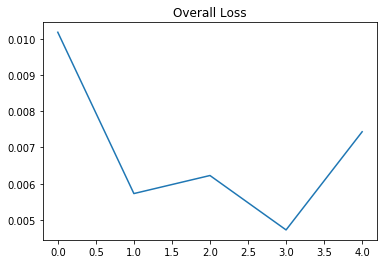

In [5]:
plt.plot(loss_records)
plt.title('Overall Loss')
plt.show()

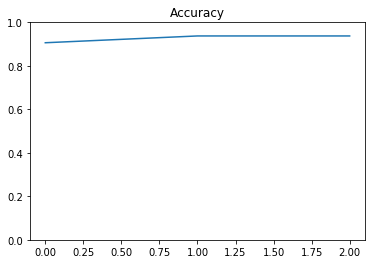

In [6]:
plt.plot(acc_records)
plt.title('Accuracy')
plt.ylim(0, 1.0)
plt.show()